In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import train test split fromo sklearn
from sklearn.model_selection import train_test_split
import pycountry_convert
from pipeline_functions import *
import copy
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# dane = pd.read_excel('/Users/adammajczyk/Dokumenty-lokalne/DANE/online_retail_II.xlsx')
dane = pd.read_excel('online_retail_II.xlsx')

In [3]:
dane = initial_transform(dane)

In [4]:
dane = add_continent_and_eu_columns(dane)

In [5]:
dane, map_ = encode_stockcode(dane)

In [6]:
dane

,Invoice,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,Day,TotalPrice,YearMonth,is_logged,Continent,StockCodeHash
0,489434,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,2009,1,83.40,2009-12,1,EU_UK,85048
1,489434,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,81.00,2009-12,1,EU_UK,6322481347366484198
2,489434,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,81.00,2009-12,1,EU_UK,-2868969455294885734
3,489434,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,12,2009,1,100.80,2009-12,1,EU_UK,22041
4,489434,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,12,2009,1,30.00,2009-12,1,EU_UK,21232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525456,538171,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,12,2010,9,5.90,2010-12,1,EU_UK,22271
525457,538171,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,12,2010,9,3.75,2010-12,1,EU_UK,22750
525458,538171,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,12,2010,9,3.75,2010-12,1,EU_UK,22751
525459,538171,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,12,2010,9,7.50,2010-12,1,EU_UK,20970


In [7]:
#split data in train test validation 0.8 0.1 0.1
train, test = train_test_split(dane, test_size=0.2)
train, val = train_test_split(train, test_size=0.125)


In [8]:
# plot price by date on x axis for stockcode 20979
plt.figure(figsize=(15,5))
plt.plot(train[train['StockCodeHash'] == 20979].groupby('YearMonth')['Quantity'].mean())




KeyError: 'StockCode'

<Figure size 1500x500 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

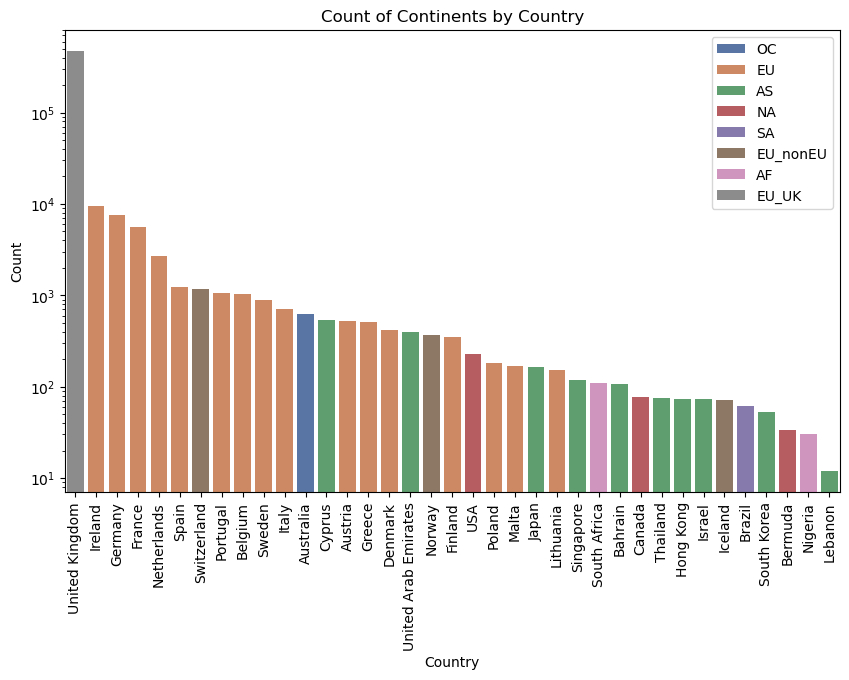

In [ ]:
warnings.filterwarnings("ignore")
continent_counts = dane.groupby('Country')['Continent'].value_counts().reset_index(name='Count')
sorted_countries = continent_counts.groupby('Country').sum().sort_values(by='Count', ascending=False).index

plt.figure(figsize=(10, 6))

# Create a bar plot
plt.figure(figsize=(10, 6))

sns.barplot(x='Country', y='Count', hue='Continent', data=continent_counts,
            palette='deep', dodge=False, order=sorted_countries)

# Set labels and title
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Continents by Country')
plt.yscale("log")
# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Add legend
plt.legend()

# Show the plot
plt.show()
warnings.filterwarnings("default")


In [10]:

def add_moving_mean_columns(df):

    df_price = df.groupby(['Year', 'Month', 'StockCodeHash','is_logged']).agg({'Price': 'mean'})
    df_price = df_price.reset_index()
    df_price = df_price.pivot_table(index=['Year', 'Month', 'StockCodeHash'], columns='is_logged', values='Price')

    # Rename the columns
    df_price = df_price.rename(columns={0: 'price_unlogged', 1: 'price_logged'})

    # Reset the index to convert the result back to a DataFrame
    df_price = df_price.reset_index()
    df_price["price_logged"].fillna(df_price["price_unlogged"]/2,inplace=True)
    df_price["price_unlogged"].fillna(df_price["price_logged"]*2,inplace=True)


    df_grouped = df.groupby(['Year', 'Month', 'StockCodeHash', 'Continent']).agg({'Quantity': 'sum'})
    df_grouped = df_grouped.reset_index()
    
    # mr. worldwide
    quantities_total = df_grouped.groupby(['Year', 'Month', 'StockCodeHash']).agg({'Quantity': 'sum'}).reset_index().rename(columns={'Quantity': 'quantity_month_worldwide'})
    quantities_total["mean_worldwide"] = quantities_total.groupby("StockCodeHash")["quantity_month_worldwide"].rolling(window=3).mean().reset_index(level=0, drop=True)
    quantities_total["weighted_mean_worldwide"] = quantities_total.groupby("StockCodeHash")["quantity_month_worldwide"].ewm(span=3, adjust=False).mean().reset_index(level=0, drop=True)
    quantities_total["mean_worldwide"].fillna(quantities_total["quantity_month_worldwide"],inplace=True)

    

    
    df_grouped = df_grouped.merge(quantities_total, on=['Year', 'Month', 'StockCodeHash'], how='left').rename(columns={'Quantity': 'quantity_month_continent'})
    df_grouped["mean_continent"] = df_grouped.groupby("StockCodeHash")["quantity_month_continent"].rolling(window=3).mean().reset_index(level=0, drop=True)
    df_grouped["weighted_mean_continent"] = df_grouped.groupby("StockCodeHash")["quantity_month_continent"].ewm(span=3, adjust=False).mean().reset_index(level=0, drop=True)
    df_grouped["mean_continent"].fillna(df_grouped["quantity_month_continent"],inplace=True)
    
    df_grouped = df_grouped.merge(df_price, on=['Year', 'Month', 'StockCodeHash'], how='left')
    
    return df_grouped

In [11]:
df = add_moving_mean_columns(dane)

In [16]:
df

,Year,Month,StockCodeHash,Continent,quantity_month_continent,quantity_month_worldwide,mean_worldwide,weighted_mean_worldwide,mean_continent,weighted_mean_continent,price_unlogged,price_logged,StockCode
0,2009,12,-9199999027635155968,EU_UK,2,2,2.000000,2.000000,2.000000,2.000000,17.350000,8.675000,37482p
1,2009,12,-9193644585883025104,EU_UK,6,6,6.000000,6.000000,6.000000,6.000000,19.900000,9.950000,90180A
2,2009,12,-9118202005680188762,EU_UK,3,3,3.000000,3.000000,3.000000,3.000000,7.500000,3.750000,84875A
3,2009,12,-9096012095485182879,EU_UK,3,3,3.000000,3.000000,3.000000,3.000000,3.003333,1.501667,90130C
4,2009,12,-9081908561636733716,EU_UK,9,9,9.000000,9.000000,9.000000,9.000000,6.070000,5.950000,90060F
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51257,2010,12,9156484687206707618,EU_UK,4,4,3.000000,3.910156,3.000000,3.642578,1.690000,1.650000,90059E
51258,2010,12,9181073000786841599,EU_UK,6,6,62.666667,58.893799,35.666667,32.716109,2.500000,1.250000,85049B
51259,2010,12,9192062360377125692,EU,3,53,106.666667,94.270752,67.000000,51.194528,11.000000,5.500000,15056P
51260,2010,12,9192062360377125692,EU_UK,50,53,106.666667,94.270752,70.666667,50.597264,11.000000,5.500000,15056P


In [ ]:
similar = pd.read_csv("df_most_similar_indexes.csv",index_col=0).drop(columns=["word2vec_vector"])

In [ ]:
s =similar.loc[0][1]
s = s.replace("[", "").replace("]", "").split()

# Convert the list of strings to a NumPy array
arr = np.fromstring(" ".join(s), dtype=str)

/tmp/ipykernel_22481/1280851033.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(" ".join(s), dtype=str)


ValueError: zero-valued itemsize